In [38]:
# Imports
import os
import mne
from mayavi import mlab
import locale

In [54]:
# Parameters
subject = 'Subject_02'  # This subject name should consistance with FreeSurfer
spacing = 'oct6'  # 4098 sources per hemisphere
raw_path = os.path.join('/nfs/diskstation/zccdata/RSVP_data/rawdata/20190326_RSVP_MEG_maxuelin/S02_lixiangTHU_20190326_05.ds')
epochs_path = os.path.join('/nfs/diskstation/zccdata/RSVP_data/epochs_freq_1.0_50.0/MEG_S02_R05/raw-epo.fif')
trans_path = os.path.join('Subject_02-trans.fif')

band = (0, 4, 'Delta')

In [40]:
# Run `mne coreg` to generate alignment `*-trans.fif` file.
# It is a GUI working requires locations of three fixing points.
# Fixing points' location can be read from `FreeSurfer` GUI.

# Run `mne watershed_bem -s [subject]` before continue.
# To generate surfaces files.

In [41]:
# Source space
fname = '%s-%s-src.fif' % (subject, spacing)
if os.path.exists(fname):
    src = mne.read_source_spaces(fname)
else:
    src = mne.setup_source_space(subject, spacing=spacing)
    mne.write_source_spaces(fname, src)
print(src)

    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
<SourceSpaces: [<surface (lh), n_vertices=166546, n_used=4098, coordinate_frame=MRI (surface RAS)>, <surface (rh), n_vertices=166009, n_used=4098, coordinate_frame=MRI (surface RAS)>]>


In [42]:
# BEM surfaces
fname = '%s-5120-5120-5120-bem.fif' % subject
if os.path.exists(fname):
    model = mne.read_bem_surfaces(fname)
else:
    model = mne.make_bem_model(subject)
    mne.write_bem_surfaces(fname, model)
print(model)

    3 BEM surfaces found
    Reading a surface...
[done]
    Reading a surface...
[done]
    Reading a surface...
[done]
    3 BEM surfaces read
[{'id': 4, 'sigma': 0.30000001192092896, 'np': 2562, 'ntri': 5120, 'coord_frame': array([5], dtype=int32), 'rr': array([[ 0.00138987, -0.01787379,  0.11673952],
       [ 0.08178807, -0.01788683,  0.07508692],
       [ 0.02811323,  0.06385667,  0.0762431 ],
       ...,
       [ 0.01549554,  0.00456711, -0.12759635],
       [ 0.00391285,  0.00804006, -0.12724073],
       [ 0.0066569 , -0.00320109, -0.12763147]]), 'nn': array([[-1.4197640e-05,  1.3890559e-18,  1.0000000e+00],
       [ 8.9454746e-01,  0.0000000e+00,  4.4697300e-01],
       [ 2.7644274e-01,  8.5070127e-01,  4.4708699e-01],
       ...,
       [ 9.0630502e-02,  1.4721242e-01, -9.8494399e-01],
       [ 1.3215269e-02,  1.7234801e-01, -9.8494744e-01],
       [ 3.4699615e-02,  1.0679164e-01, -9.9367577e-01]], dtype=float32), 'tris': array([[   0,  644,  642],
       [ 642,  643,  162],
 

In [43]:
# BEM solution
fname = '%s-5120-5120-5120-bem-sol.fif' % subject
if os.path.exists(fname):
    bem_sol = mne.read_bem_solution(fname)
else:
    bem_sol = mne.make_bem_solution(model)
    mne.write_bem_solution(fname, bem_sol)
print(bem_sol)

Loading surfaces...
Three-layer model surfaces loaded.

Loading the solution matrix...

Loaded linear_collocation BEM solution from Subject_02-5120-5120-5120-bem-sol.fif
<ConductorModel  |  BEM (3 layers)>


In [44]:
# Read raw and trans; Compute fwd
# Raw, only raw.info is used in below.
# So preload=False is OK and high-efficient.
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")  # Used by load raw_ctf
raw = mne.io.read_raw_ctf(raw_path, preload=False, verbose=False)
print(raw.info)

# Trans
trans = mne.read_trans(trans_path)
print(trans)

# Fwd: forward solution based on raw.info, trans, surfaces and BEM solution.
fwd = mne.make_forward_solution(raw.info, trans, src, bem_sol)

<Info | 22 non-empty fields
    bads : list | 0 items
    ch_names : list | SCLK01-177, BG1-4503, BG2-4503, BG3-4503, BP1-4503, ...
    chs : list | 409 items (MISC: 108, REF_MEG: 29, MAG: 272)
    comps : list | 5 items
    ctf_head_t : Transform | 3 items
    custom_ref_applied : bool | False
    dev_ctf_t : Transform | 3 items
    dev_head_t : Transform | 3 items
    dig : Digitization | 3 items (3 Cardinal)
    events : list | 0 items
    experimenter : str | 6 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 1 items
    lowpass : float | 600.0 Hz
    meas_date : NoneType | unspecified
    meas_id : dict | 4 items
    nchan : int | 409
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 1200.0 Hz
    subject_info : dict | 1 items
    acq_pars : NoneType
    acq_stim : NoneType
    description : NoneType
    device_info : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    h

In [60]:
# Read epochs; Compute cov and inv.

# The order is epochs ==> cov ==> inv.

# Epochs
# Todo: Now is only read single epochs.
#       Awaiting read several epochs and concentrate them.
epochs = mne.read_epochs(epochs_path, verbose=False)
epochs = epochs.filter(l_freq=band[0], h_freq=band[1], n_jobs=32, verbose=True)
print(epochs.info)

xdawn = mne.preprocessing.Xdawn(n_components=6, reg='diagonal_fixed')
xdawn.fit(epochs)
epochs_xdawn = xdawn.apply(epochs.copy(), event_id=['odd'])['odd']

# Compute cov and inv
# Cov: Covariance using empirical as background noisy.
# Inv: Inverse operator based on fwd and cov.
cov = mne.compute_covariance(epochs, method='empirical')
inv = mne.minimum_norm.make_inverse_operator(raw.info, fwd, cov, loose='auto')

cov_xdawn = mne.compute_covariance(epochs_xdawn, method='empirical')
inv_xdawn = mne.minimum_norm.make_inverse_operator(raw.info, fwd, cov_xdawn, loose='auto')

Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 331 samples (1.655 sec)



<ipython-input-60-3a00a330e01f>:9: RuntimeWarning: filter_length (331) is longer than the signal (240), distortion is likely. Reduce filter length or filter a longer signal.
  epochs = epochs.filter(l_freq=band[0], h_freq=band[1], n_jobs=32, verbose=True)
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 1243 tasks      | elapsed:    4.0s
[Parallel(n_jobs=32)]: Done 69032 tasks      | elapsed:   10.4s
[Parallel(n_jobs=32)]: Done 100790 tasks      | elapsed:   13.2s
[Parallel(n_jobs=32)]: Done 139184 tasks      | elapsed:   16.8s
[Parallel(n_jobs=32)]: Done 186110 tasks      | elapsed:   21.1s
[Parallel(n_jobs=32)]: Done 241568 tasks      | elapsed:   26.5s
[Parallel(n_jobs=32)]: Done 305558 tasks      | elapsed:   32.6s
[Parallel(n_jobs=32)]: Done 378080 tasks      | elapsed:   39.3s
[Parallel(n_jobs=32)]: Done 392224 out of 392224 | elapsed:   40.1s finished


<Info | 23 non-empty fields
    bads : list | 0 items
    ch_names : list | MLC11-4503, MLC12-4503, MLC13-4503, MLC14-4503, ...
    chs : list | 272 items (MAG: 272)
    comps : list | 0 items
    ctf_head_t : Transform | 3 items
    custom_ref_applied : bool | False
    dev_ctf_t : Transform | 3 items
    dev_head_t : Transform | 3 items
    dig : Digitization | 3 items (3 Cardinal)
    events : list | 0 items
    experimenter : str | 6 items
    file_id : dict | 4 items
    highpass : float | 1.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 1 items
    lowpass : float | 4.0 Hz
    meas_date : tuple | 2019-03-26 15:04:00 GMT
    meas_id : dict | 4 items
    nchan : int | 272
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 200.0 Hz
    subject_info : dict | 1 items
    acq_pars : NoneType
    acq_stim : NoneType
    description : NoneType
    device_info : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : N

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 56
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 62 (210 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "odd"...
    Picked 272 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  89.7% variance
    Combining the current components...
    dSPM...
[done]
Evoked


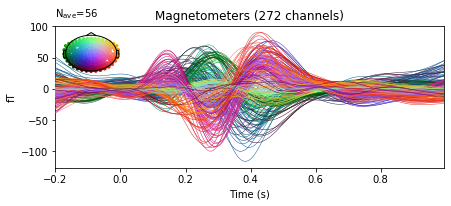

Resident


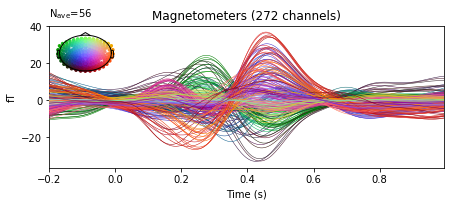

Done
Using control points [3.59223791 4.1214596  8.87988727]


In [62]:
# Plot evoked
# evoked: the mean epochs of interest.
# stc: The source estimates.
evoked = epochs_xdawn['odd'].average()
stc, resident = mne.minimum_norm.apply_inverse(evoked, inv, lambda2=0.1, return_residual=True)
print('Evoked')
evoked.plot(spatial_colors=True)
print('Resident')
resident.plot(spatial_colors=True)
print('Done')
# time_viewer=True means stc is plotted in interface manner
stc.plot(time_viewer=True)

In [64]:
morph = mne.compute_source_morph(stc, subject_from=subject, subject_to='fsaverage')
stc_fsaverage = morph.apply(stc)
stc_fsaverage.plot(time_viewer=True)

Using control points [3.43459487 3.92480642 8.65833886]
